<a href="https://colab.research.google.com/github/preetamjumech/Cats_Vs_Dogs_CNN_from_scratch/blob/main/Preetam_Saha_cats_vs_dogs_practice_24_09_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip dogs-vs-cats.zip

In [ ]:
!unzip train.zip
!unzip test1.zip

In [6]:
import re,shutil

In [7]:
try:
  os.makedirs("Train")
  os.makedirs("Train/Dog")
  os.makedirs("Train/Cat")
except:
  pass

In [8]:
try:
  os.makedirs("Val")
  os.makedirs("Val/Dog")
  os.makedirs("Val/Cat")
except:
  pass

In [10]:
len(os.listdir("train"))

25000

In [11]:
len(os.listdir("test1"))

12500

In [12]:
import numpy as np

In [13]:
np.random.seed(0)
index = np.array(range(len(os.listdir("train"))))
index

array([    0,     1,     2, ..., 24997, 24998, 24999])

In [14]:
np.random.shuffle(index)

In [16]:
train_img_index = np.array(os.listdir("train"))[index[:15000]]
train_img_index

array(['cat.7258.jpg', 'cat.12372.jpg', 'cat.2064.jpg', ...,
       'cat.139.jpg', 'cat.5065.jpg', 'cat.3839.jpg'], dtype='<U13')

In [17]:
val_img_index = np.array(os.listdir("train"))[index[15000:]]
val_img_index

array(['cat.4017.jpg', 'cat.11854.jpg', 'dog.5903.jpg', ...,
       'cat.10670.jpg', 'dog.1897.jpg', 'cat.8449.jpg'], dtype='<U13')

In [18]:
for file in train_img_index:
  if re.findall("dog.+",file):
    shutil.move("train/"+file,"Train/Dog/"+file)
  elif re.findall("cat.+",file):
    shutil.move("train/"+file,"Train/Cat/"+file)
  else:
    continue

In [19]:
for file in val_img_index:
  if re.findall("dog.+",file):
    shutil.move("train/"+file,"Val/Dog/"+file)
  elif re.findall("cat.+",file):
    shutil.move("train/"+file,"Val/Cat/"+file)
  else:
    continue

In [20]:
len(os.listdir("train"))

0

In [21]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [22]:
from torch.utils.data import DataLoader

In [24]:
tranf = transforms.Compose([transforms.PILToTensor(),
                            transforms.Resize(size=(256,256)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip()
])

In [25]:
train_loader = DataLoader(ImageFolder("Train",transform=tranf),
                          batch_size=32,shuffle=True)

In [26]:
val_loader = DataLoader(ImageFolder("Val",transform=tranf),
                        batch_size=128,shuffle=False)

In [27]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

In [34]:
class Cat_Vs_Dog(nn.Module):
  def __init__(self):
    super(Cat_Vs_Dog,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.bn3 = nn.BatchNorm2d(num_features=64)
    self.drop = nn.Dropout2d()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1 = nn.Linear(in_features=8*8*256,out_features = 512)
    self.fc2 = nn.Linear(in_features=512,out_features = 64)
    self.fc3 = nn.Linear(in_features=64,out_features = 2)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = self.bn1(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = self.bn2(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    
    x = self.bn3(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = self.pool(x)

    x = x.view(x.size()[0],-1)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x


In [35]:
model = Cat_Vs_Dog()

In [36]:
opt = Adam(model.parameters(),lr = 0.0001)

In [37]:
import torchsummary

In [38]:
torchsummary.summary(model,input_size=(3,256,256),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 32, 128, 128]           4,640
         MaxPool2d-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 64, 64]          18,496
         MaxPool2d-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 128, 32, 32]          73,856
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         295,168
        MaxPool2d-13            [-1, 256, 8, 8]               0
           Linear-14                  [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [39]:
from tqdm import tqdm

In [40]:
def train(model,train_loader,opt):
  train_loss = 0.0
  model.train()

  for batch,target in tqdm(train_loader):
    batch = batch.float().to("cuda")
    target = target.to("cuda")

    opt.zero_grad()
    output = model(batch)
    loss = F.cross_entropy(output,target)
    loss.backward()
    opt.step()
    train_loss += loss.item()
  return train_loss

In [42]:
def validate(model,val_loader,opt):
  val_loss = 0.0
  model.eval()
  with torch.no_grad():
    for batch,target in tqdm(val_loader):
      batch = batch.float().to("cuda")
      target = target.to("cuda")

      output = model(batch)
      loss = F.cross_entropy(output,target)
      val_loss += loss.item()
  return val_loss


In [43]:
import seaborn as sns

In [44]:
model = model.to("cuda")
hist = {"train_loss":[],"val_loss":[]}
for epoch in range(1):
  hist["train_loss"].append(train(model,train_loader=train_loader,opt=opt))
  hist["val_loss"].append(validate(model,val_loader,opt))

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 79/79 [01:05<00:00,  1.20it/s]


In [45]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [46]:
model.conv1.register_forward_hook(get_features("conv_layer_1"))
model.conv2.register_forward_hook(get_features("conv_layer_2"))

In [47]:
for batch, _ in train_loader:
  break

In [48]:
batch.shape

torch.Size([32, 3, 256, 256])

In [49]:
img = batch[10]

In [50]:
import matplotlib.pyplot as plt

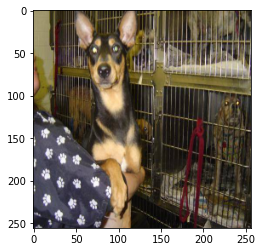

In [51]:
plt.imshow(img.permute(1,2,0))

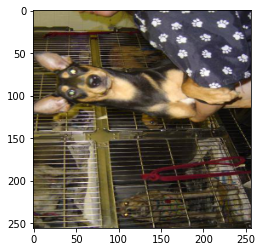

In [52]:
plt.imshow(img.permute(2,1,0))

In [54]:
out = model(img.float().reshape(-1,3,256,256).to("cuda"))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [55]:
out

tensor([[-0.4031,  0.3704]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [56]:
features["conv_layer_1"].size()

torch.Size([1, 16, 256, 256])

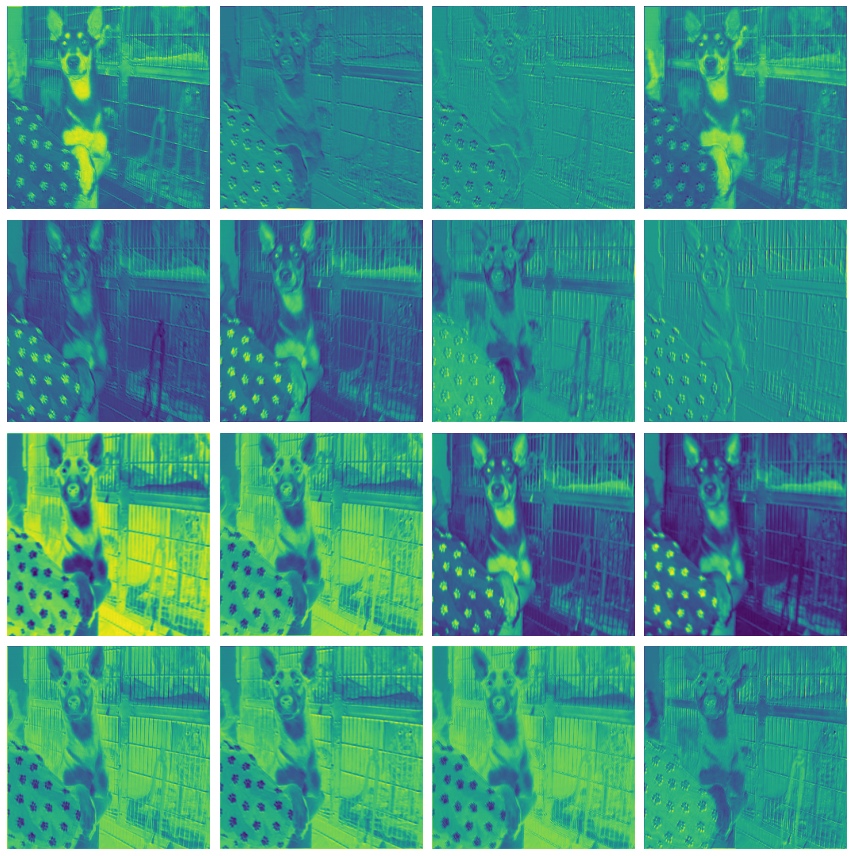

In [58]:
plt.figure(figsize = (12,12))
for idx in range(16):
  plt.subplot(4,4,idx+1)
  plt.axis("off")
  plt.imshow(features["conv_layer_1"][0,idx,:,:].detach().cpu().numpy())
plt.tight_layout()

In [59]:
features["conv_layer_2"].size()

torch.Size([1, 32, 128, 128])

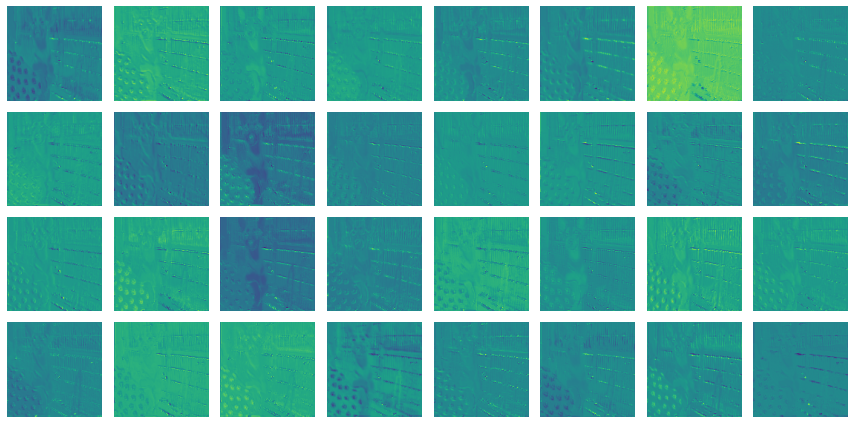

In [63]:
plt.figure(figsize=(12,6))
for idx in range(32):
  plt.subplot(4,8,idx+1)
  plt.axis("off")
  plt.imshow(features["conv_layer_2"][0,idx,:,:].detach().cpu().numpy())
plt.tight_layout()

In [64]:
from torchvision.models import vgg16, VGG16_Weights

In [66]:
vgg_16 = vgg16(weights = VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [67]:
torchsummary.summary(vgg_16, input_size=(3,256,256),device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [68]:
list(vgg_16.children())[:2]

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [71]:
base_model = nn.Sequential(*list(vgg_16.children())[:2])
for param in base_model.parameters():
  param.requires_grad = False

In [75]:
head_model = nn.Sequential(nn.Flatten(),
                           nn.Linear(in_features=25088,out_features=128),
                           nn.ReLU(),
                           nn.Linear(in_features=128,out_features=32),
                           nn.ReLU(),
                           nn.Linear(in_features=32,out_features=2))

In [73]:
512*7*7

25088

In [77]:
cat_vs_dog_tl = nn.Sequential(*[base_model,head_model])

In [78]:
torchsummary.summary(cat_vs_dog_tl,input_size=(3,256,256),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [79]:
cat_vs_dog_tl = cat_vs_dog_tl.to("cuda")
hist = {"train_loss":[],"val_loss":[]}
for epoch in range(1):
  hist["train_loss"].append(train(cat_vs_dog_tl,train_loader,opt))
  hist["val_loss"].append(validate(cat_vs_dog_tl,val_loader,opt))

100%|██████████| 79/79 [01:56<00:00,  1.47s/it]


In [80]:
print(hist)

{'train_loss': [739.4769934415817], 'val_loss': [125.3449996560812]}
